# 3. **BONUS : Extending the Framework even further

1. Extend the Optimization class by implementing another step length controller named RMSProp (slide 21/27 DL). Research about this Adaptive Step Length controller and explain how RMSProp helps to avoid exploding gradients. Implement the RMSProp algorith and compare its performance with Bold-Driver Step Length controller for the logistic regression problem.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import collections

In [36]:
class Optimization():
    def __init__(self,X,y,loss):
        self.X = X
        self.y = y
        self.loss = loss
    # BOLD DRIVER IMPLEMENTATION    
    def bold_driver(self,loss_old,loss_new,mew_old,mew_plus,mew_minus):
        if loss_new>loss_old:
            mu = mew_old*mew_minus
        else:
            mu = mew_old*mew_plus
        return mu
    # SGD
    def min_sgd(self, theta0, mu, C, K, epsilon):
        theta = theta0
        J_hist = np.zeros((K,1))
        theta_val = np.zeros((K,self.X.shape[1]))
        for i in range(K):
            for j in range(C):
                index = np.random.randint(len(self.y))
                xvar = self.X[index:index+1]
                yvar = self.y[index:index+1]
                losses, gradient, _ = self.loss(self, xvar, yvar,theta)
                J_hist[i] += losses.ravel()
                mu = self.bold_driver(J_hist[i-1],J_hist[i],mu,0.01,0.5)
                theta = theta - mu*gradient
                if np.all(np.abs(gradient**2) <= epsilon):
                    break     
            J_hist[i] /= C       
            theta_val[i] = theta.reshape(1,self.X.shape[1])
        return J_hist, theta_val, theta

    #RMS_MU UPDATE    
    def rms_mew_update(self,mu,r):
        mu = mu/(1e-06+np.sqrt(r))
        return mu
    # RMS_PROP IMPLEMENTATION
    def rmsprop(self,theta0, mu, C, K, epsilon):
        theta = theta0
        J_hist = np.zeros((K,1))
        theta_val = np.zeros((K,self.X.shape[1]))
        eta = 0.9
        for i in range(K):
            r=0
            for j in range(C):
                index = np.random.randint(len(self.y))
                xvar = self.X[index:index+1]
                yvar = self.y[index:index+1]
                losses, gradient, _ = self.loss(self, xvar, yvar,theta)
                J_hist[i] += losses.ravel()
                r = eta*r +(1-eta)*gradient.dot(gradient.T)
                mu_new = self.rms_mew_update(mu,r)
                theta = theta - mu*gradient
                if np.all(np.abs(gradient**2) <= epsilon):
                    break     
            J_hist[i] /= C       
            theta_val[i] = theta.reshape(1,self.X.shape[1])
        return J_hist, theta_val, theta

    
                                   

In [37]:
class Loss():
    def __init__(self, X, y):
        super().__init__()
    # CROSS ENTROPY LOSS
    def cross_entropy(self, X,y, theta):
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        return -1/M*(y.T@np.log(p) + (1-y).T@np.log((1-p))),-X.T.dot(y - p), X.T@W@X   
    # L1 REGULARIZATION
    def l1(self, X,y, theta):
        lamda = 0.1
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        return -1/M*(y.T@np.log(p) + (1-y).T@np.log((1-p)) + lamda*abs(np.sum(theta))),-X.T.dot(y - p), X.T@W@X
    # L2 REGULARIZATION
    def l2(self, X,y, theta):
        lamda = 0.1
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        return -1/M*(y.T@np.log(p) + (1-y).T@np.log((1-p)) + lamda*np.dot(theta.T,theta)),-X.T.dot(y - p), X.T@W@X
    # ELASTIC NET LOSS
    def elastic_net(self,X, y, theta):
        lamda = 0.1
        M = len(y)
        p = 1/(1+np.exp(-X@theta))
        W = np.diag((p*(1-p)).reshape(-1))
        return -1/M*(y.T@np.log(p) + (1-y).T@np.log((1-p)) + lamda*abs(np.sum(theta)) + lamda*np.dot(theta.T,theta)),-X.T.dot(y - p), X.T@W@X

In [38]:
class LogisticRegression:
    def fit(self, X, y, learning_rate = 0.01, maxiter = 500, batch_size = 100, tolerance = 10e-5, optimizer = 'SGD'):
        theta0 = np.zeros((X.shape[1],1))
        
        if optimizer == 'SGD':
            optimization = Optimization(X, y, loss = Loss.cross_entropy)
            J_hist, theta_val, theta  = optimization.min_sgd(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, epsilon= tolerance)
        elif optimizer == 'RMS_SGD':
            optimization = Optimization(X, y, loss = Loss.elastic_net)
            J_hist, theta_val, theta  = optimization.rmsprop(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, epsilon= tolerance)
        elif optimizer == 'L1_SGD':
            optimization = Optimization(X, y, loss = Loss.l1)
            J_hist, theta_val, theta  = optimization.min_sgd(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, epsilon= tolerance)
        elif optimizer == 'L2_SGD':
            optimization = Optimization(X, y, loss = Loss.l2)
            J_hist, theta_val, theta  = optimization.min_sgd(theta0 = theta0,mu = learning_rate, C = batch_size,K = maxiter, epsilon= tolerance)
        else: raise Exception("Please enter optimizer's name correctly: 'SGD' or 'RMS_PROP'")  
        self.theta = theta
        self.J_hist = J_hist
        self.theta_val = theta_val
        return theta
    def predict(self, X, class_prob = False):
        if class_prob == True:
            return 1/(1+np.exp(-X@self.theta))
        else:
            return ((1/(1+np.exp(-X@self.theta)))>= 0.5).astype(int)
        return pred
    def plot_loss(self, X, y):
        J_hist_pred = np.zeros((self.theta_val.shape[0],1))
        for i in range(self.theta_val.shape[0]):
            temp_theta = self.theta_val[i,:]
            p = 1/(1+np.exp(-X@temp_theta))
            J_hist_pred[i] = -1/len(y)*(y.T@np.log(p) + (1-y).T@np.log((1-p)))
        f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
        sns.set_style('white')
        ax0.plot(range(len(self.J_hist)), self.J_hist, 'blue')
        ax0.set_title("Cost Function of Train")
        ax0.set_xlabel("Number of Iterations")
        ax0.set_ylabel("Cost")
        ax1.plot(range(len(J_hist_pred)), J_hist_pred, 'red')
        ax1.set_title("Cost Function of Test")
        ax1.set_xlabel("Number of Iterations")
        ax1.set_ylabel("Cost")
        plt.show()
    def plot_metrics(self, y_true, y_pred):
        fp, fn, tp, tn = 0, 0, 0, 0
        for true, pred in zip(y_true, y_pred):
            if pred == true:
                if pred == 1: tp +=1
                else: tn+=1
            else:
                if pred == 1: fp +=1
                else: fn+=1
        confusion_matrix = np.array([[tp,fp], [fn, tn]])
        accuracy = np.round((tp+tn)/len(y_true),3)
        precision = np.round(tp/(tp+fp),3)
        recall = np.round(tp/(tp+fn),3)
        f1 = np.round((2*(precision*recall))/(precision + recall),3)
        print('-----------------------------------------------------------------------------------------------')
        print('|',f'Accuracy: {accuracy}','|' ,f'Recall: {recall}', ' |')
        print('|',f'Precision: {precision}','|', f'F1-score: {f1}', '|' )
        print('-----------------------------------------------------------------------------------------------')
        
        plt.figure(figsize=(10,7))
        sns.set(font_scale=1.4) 
        labels = ['1','0']
        sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 12}, fmt='g', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Confusion Matrix')
        plt.show()
        
        
        
    

In [39]:
logistic = pd.read_csv('logistic.csv')
X = logistic.loc[:,'X1':'X30']
y = logistic.Y
x_scaled = (np.array(X) - np.mean(X, axis = 0).ravel())\
/(np.std(X,axis = 0).ravel())
x_scaled = np.hstack((np.ones((x_scaled.shape[0],1)),x_scaled))
x_scaled

mapping = {'M':1, 'B':0}
y = y.map(mapping)
np.random.seed(0)
mask = np.random.rand(len(x_scaled)) <= 0.80
training_data = x_scaled[mask]
testing_data = x_scaled[~mask]
training_y = y[mask]
testing_y = y[~mask]
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")
training_y = training_y[:, np.newaxis]
testing_y = testing_y[:, np.newaxis]

No. of training examples: 458
No. of testing examples: 111


#### Cross Entropy Loss and SGD with Bold_Driver Implementation

 
 Logistic Regression Model with Cross Entropy Loss and SGD with Bold_Driver Implementation:
 

 Training Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.841 | Recall: 0.892  |
| Precision: 0.744 | F1-score: 0.811 |
-----------------------------------------------------------------------------------------------


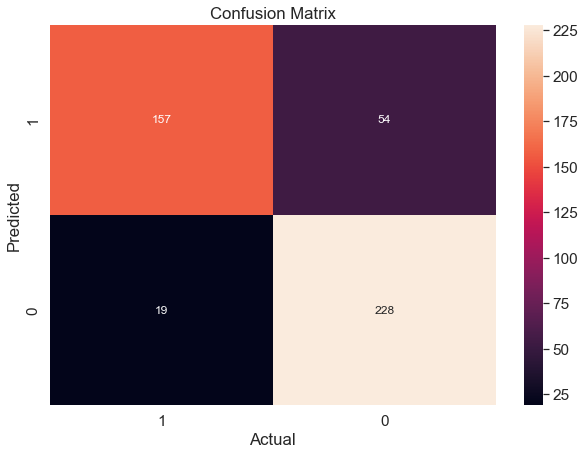


 Testing Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.829 | Recall: 0.889  |
| Precision: 0.681 | F1-score: 0.771 |
-----------------------------------------------------------------------------------------------


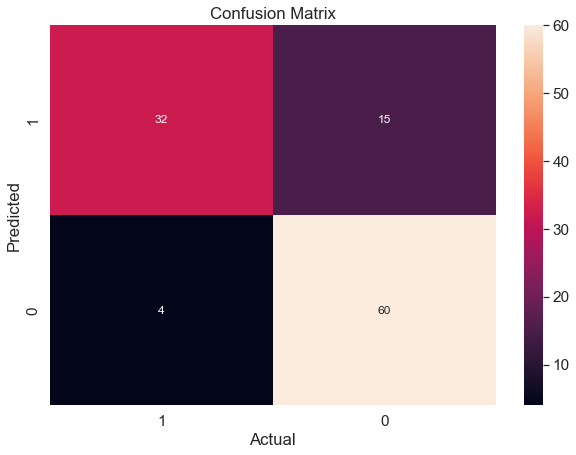

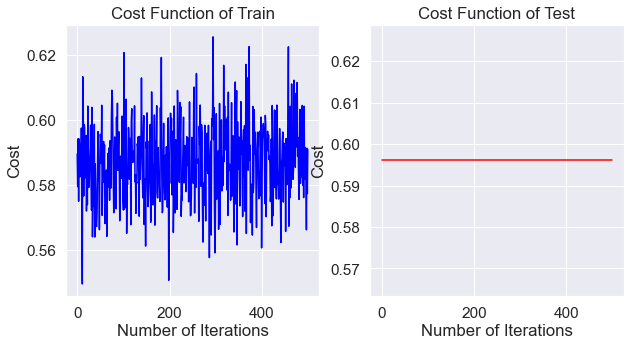

In [40]:
log_reg = LogisticRegression()
theta= log_reg.fit(training_data, training_y,  learning_rate = 0.1, maxiter = 500, batch_size = 100, tolerance = 10e-5, optimizer = 'SGD')
# print("Number of paramters :", theta.shape)
pred_log = log_reg.predict(testing_data, class_prob = True)
# print(pred_log)
pred_log_train= log_reg.predict(training_data)
# print(pred_log_train)
print(" \n Logistic Regression Model with Cross Entropy Loss and SGD with Bold_Driver Implementation:\n ")
print("\n Training Set Results:\n")
log_reg.plot_metrics(training_y,pred_log_train)
pred_log = log_reg.predict(testing_data)
print("\n Testing Set Results:\n")
log_reg.plot_metrics(testing_y,pred_log)
log_reg.plot_loss(testing_data,testing_y)

### ADAPTIVE STEP LENGTH CONTROLLER

The Adaptive Gradient method, also known as AdaGrad, employs the sum of gradient squared instead of the sum of gradient to modify the gradient in different directions. This is similar to how momentum keeps track of the sum of gradient. Some features in ML optimization are very scarce. Since sparse features typically have low average gradients, they are trained at a significantly slower rate. Setting separate learning rates for each feature is one approach to address this, but this quickly becomes chaotic.

AdaGrad approaches this issue with the notion that the more frequently a feature has been updated, the less frequently it will be updated going forward, giving other features (such as sparse features) a chance to catch up. The cumulative sum of gradient squared effectively expresses how far you have progressed in this dimension by measuring how often you have updated this feature.

This trait makes saddle point escape considerably easier for AdaGrad and other related gradient-squared-based algorithms like RMSProp and Adam. While Momentum (or similarly, gradient descent) adopts the strategy of "let me slide down the steep slope first and perhaps worry about the slower direction later," AdaGrad will follow a straight path. The saddle point, where slopes in both directions are 0, is sometimes where pure gradient descent will simply halt and be content.

### RMS PROP Approach

The problem of AdaGrad, however, is that it is incredibly slow. This is because the sum of gradient squared only grows and never shrinks. RMSProp (for Root Mean Square Propagation) fixes this issue by adding a decay factor.

sum_of_gradient_squared = previous_sum_of_gradient_squared * decay_rate+ gradient² * (1- decay_rate)

delta = -learning_rate * gradient / sqrt(sum_of_gradient_squared)

theta += delta

In fact, the sum of the gradient squared is the decayed sum of the gradient squared. According to the decay rate, only recent gradient2 is important; older gradients are essentially irrelevant. In addition, the word "decay rate" is a little misleading. In contrast to the decay rate we saw for momentum, this decay rate also has a scaling impact, which reduces the entire term by a factor of (1 - decay rate). In other words, if the decay rate is set to 0.99, the step will be on the order of 10 times higher for the same learning rate since in addition to decaying, the gradient squared sum will be sqrt(1 - 0.99) = 0.1 that of AdaGrad.

The gradient squared sums for AdaGrad build up so quickly that they quickly grow enormous. They have a significant impact, and finally AdaGrad almost stops moving. On the other hand, RMSProp has always kept the squares under a manageable size because of the decay rate. As a result, RMSProp is quicker than AdaGrad.

## Elastic Net Loss With RMSPROP

 
 Logistic Regression Model with Elastic Net Loss and RMS_PROP:
 

 Training Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.985 | Recall: 0.966  |
| Precision: 0.994 | F1-score: 0.98 |
-----------------------------------------------------------------------------------------------


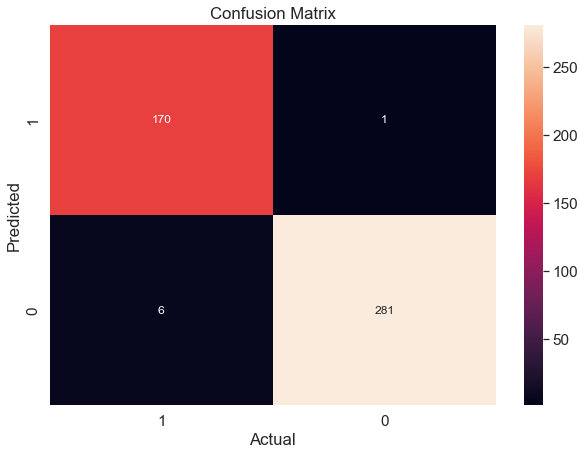


 Testing Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.964 | Recall: 0.889  |
| Precision: 1.0 | F1-score: 0.941 |
-----------------------------------------------------------------------------------------------


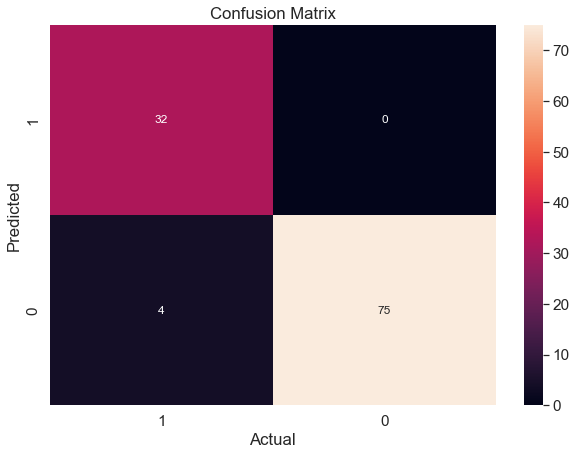

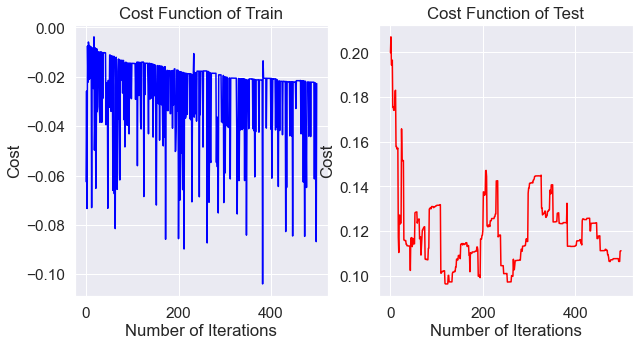

In [41]:
log_reg1 = LogisticRegression()
theta1= log_reg1.fit(training_data, training_y,  learning_rate = 0.1, maxiter = 500, batch_size = 100, tolerance = 10e-5, optimizer = 'RMS_SGD')
# print("Number of paramters :", theta.shape)
pred_log1 = log_reg1.predict(testing_data, class_prob = True)
# print(pred_log)
pred_log_train1= log_reg1.predict(training_data)
# print(pred_log_train)
print(" \n Logistic Regression Model with Elastic Net Loss and RMS_PROP:\n ")
print("\n Training Set Results:\n")
log_reg1.plot_metrics(training_y,pred_log_train1)
pred_log1 = log_reg1.predict(testing_data)
print("\n Testing Set Results:\n")
log_reg1.plot_metrics(testing_y,pred_log1)
log_reg1.plot_loss(testing_data,testing_y)

When implementing Bold driver we see that the accuray is around 83%, however, we see a much better performance when we implement the RMS Prop method. As explained above RMSprop helps avoid exploding gradients and thus results in a much improved performance as compared to Normal SGD with Bold Driver implementation. RMSProp also tries to dampen the oscillations, but in a different way than momentum. RMS prop also takes away the need to adjust learning rate, and does it automatically. More so, RMSProp choses a different learning rate for each parameter.

### 2. Extend the Loss class by implementing functions for ElasticNet (slide 10/29) regularization. Compare the performance with L1 and L2 regularization implemented in the first part.

#### L1_regularized Cross Entropy Loss and SGD

 
 Logistic Regression Model with L1_regularized Cross Entropy Loss and SGD:
 

 Training Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.838 | Recall: 0.835  |
| Precision: 0.766 | F1-score: 0.799 |
-----------------------------------------------------------------------------------------------


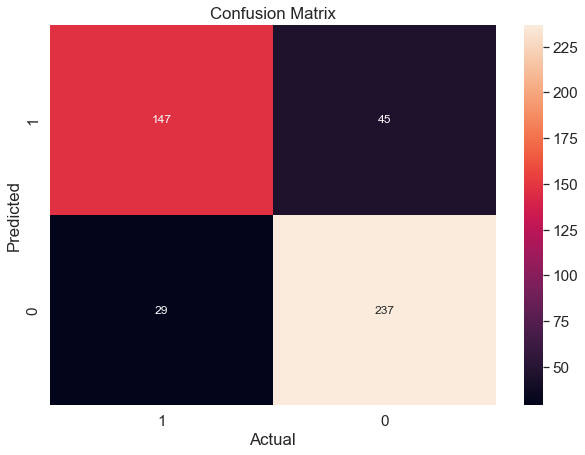


 Testing Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.784 | Recall: 0.75  |
| Precision: 0.643 | F1-score: 0.692 |
-----------------------------------------------------------------------------------------------


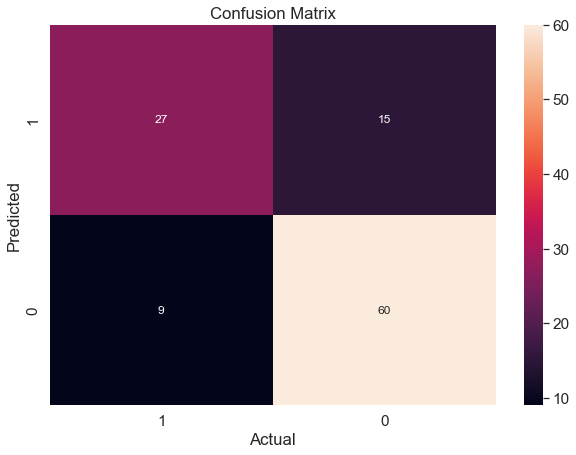

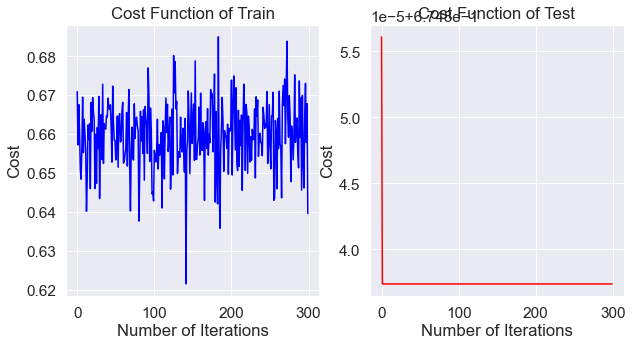

In [42]:
log_reg2 = LogisticRegression()
theta2 = log_reg2.fit(training_data, training_y,  learning_rate = 0.01, maxiter = 300, batch_size = 10, tolerance = 10e-5, optimizer = 'L1_SGD')
pred_log2 = log_reg2.predict(testing_data, class_prob = True)
pred_log_train2= log_reg2.predict(training_data)
print(" \n Logistic Regression Model with L1_regularized Cross Entropy Loss and SGD:\n ")
print("\n Training Set Results:\n")
log_reg2.plot_metrics(training_y,pred_log_train2)
pred_log2 = log_reg2.predict(testing_data)
print("\n Testing Set Results:\n")
log_reg2.plot_metrics(testing_y,pred_log2)
log_reg2.plot_loss(testing_data,testing_y)

L1 Regularization (or Lasso) adds to so-called L1 Norm to the loss value. L1 Regularization produces sparse models, i.e. models where unnecessary features don't contribute to their predictive power, which is an additional benefit and may also speed up models during inference. However, Lasso does not work that well in a high-dimensional case, i.e. where the number of samples is lower than the number of dimensions. Secondly, the main benefit of L1 regularization - i.e., that it results in sparse models - could be a disadvantage as well. For example, when you don't need variables to drop out - e.g., because you already performed variable selection - L1 might induce too much sparsity in your model 

#### L2_regularized Cross Entropy Loss and SGD

 
 Logistic Regression Model with L2-Regularized Cross Entropy Loss and SGD:
 

 Training Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.945 | Recall: 0.943  |
| Precision: 0.917 | F1-score: 0.93 |
-----------------------------------------------------------------------------------------------


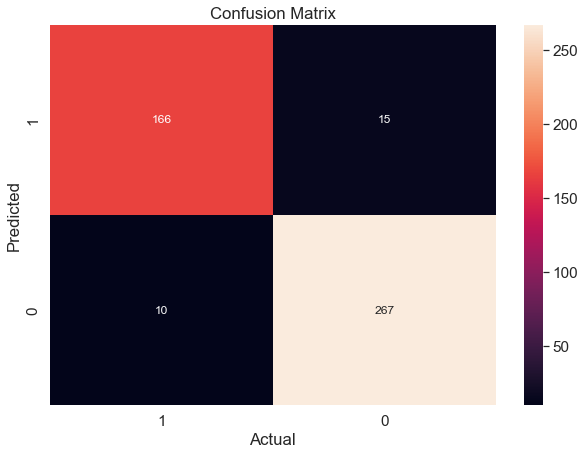


 Testing Set Results:

-----------------------------------------------------------------------------------------------
| Accuracy: 0.982 | Recall: 0.972  |
| Precision: 0.972 | F1-score: 0.972 |
-----------------------------------------------------------------------------------------------


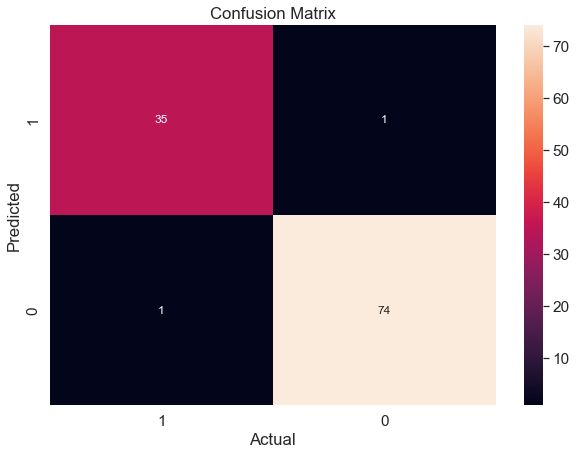

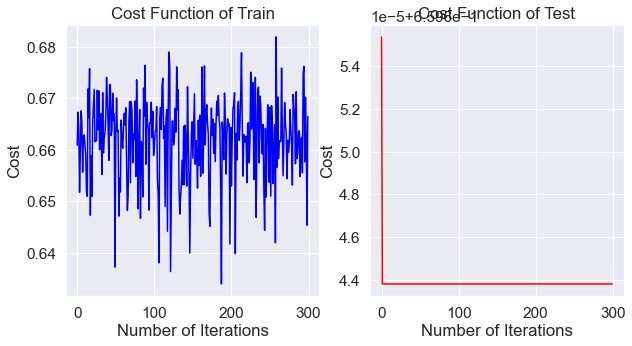

In [43]:
log_reg3 = LogisticRegression()
theta3 = log_reg3.fit(training_data, training_y,  learning_rate = 0.01, maxiter = 300, batch_size = 10, tolerance = 10e-5, optimizer = 'L2_SGD')
pred_log3 = log_reg3.predict(testing_data, class_prob = True)
pred_log_train3= log_reg3.predict(training_data)
print(" \n Logistic Regression Model with L2-Regularized Cross Entropy Loss and SGD:\n ")
print("\n Training Set Results:\n")
log_reg3.plot_metrics(training_y,pred_log_train3)
pred_log3 = log_reg3.predict(testing_data)
print("\n Testing Set Results:\n")
log_reg3.plot_metrics(testing_y,pred_log3)
log_reg3.plot_loss(testing_data,testing_y)

Another type of regularization is L2 Regularization, also called Ridge, which utilizes the L2 norm of the vector. L2 is preferred over L1 regularization primarily due to the L1 drawback that situations where high-dimensional data where many features are correlated will lead to ill-performing models, because relevant information is removed from our models. Unfortunately, L2 regularization also comes with a disadvantage due to the nature of the regularizer. It is model interpretability: due to the fact that L2 regularization does not promote sparsity, one may end up with an uninterpretable model if the dataset is high-dimensional.

#### Conclusion 

L1 regularization produces sparse models, but cannot handle "small and fat datasets".
L2 regularization can handle these datasets, but can get us into trouble in terms of model interpretability due to the fact that it does not produce the sparse solutions we may wish to find after all.

##### Elastic Net Regularization is a linear combination of L1 and L2 regularization, and produces a regularizer that has both the benefits of the L1 (Lasso) and L2 (Ridge) regularizers. 

We can also observe that Elastic net is better in terms of accuracy and other measures as compared to L1 and L2.

##### REFERENCE: https://github.com/christianversloot/machine-learning-articles/blob/main/what-are-l1-l2-and-elastic-net-regularization-in-neural-networks.md